# Brain Tumor Segmentation  Residual Unet

**Import Libraries** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input ,BatchNormalization , Activation 
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers 
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting

# **BraTs2020 Data Visualization**
**In this section, I select a sample data from Brats2020  and visualize it to see the input data**

In [2]:
Flair= nib.load('F://Thesis Group T2230051/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii')
Seg= nib.load('F://Thesis Group T2230051/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii')
T1= nib.load('F://Thesis Group T2230051/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1.nii')
T1ce= nib.load('F://Thesis Group T2230051/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii')
T2= nib.load('F://Thesis Group T2230051/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii')

**Fluid-attenuated inversion recovery (FLAIR) :**

**FLAIR is an MRI sequence with an inversion recovery set to null fluids. For example, it can be used in brain imaging to suppress cerebrospinal fluid (CSF) effects on the image, so as to bring out the periventricular hyperintense lesions, such as multiple sclerosis (MS) plaques**

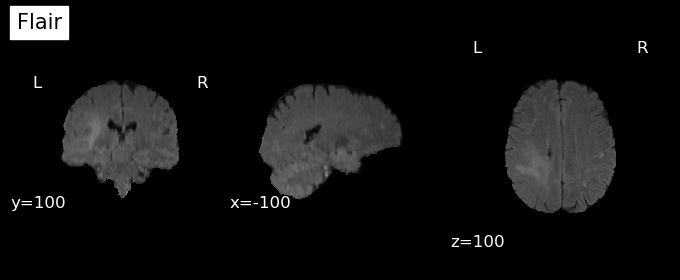

In [3]:
plotting.plot_anat(Flair,cut_coords=[-100, 100, 100],title="Flair",draw_cross =False)

**Manual segmentation that annotated by an expert**

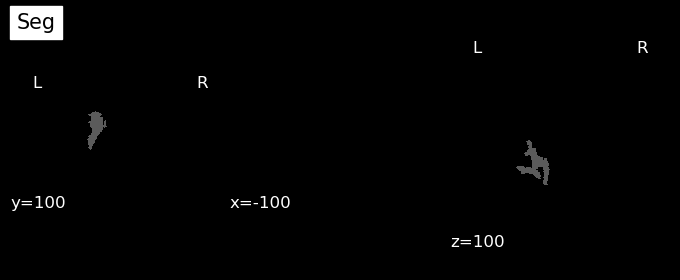

In [4]:
plotting.plot_anat(Seg,cut_coords=[-100, 100, 100],title="Seg",draw_cross =False)

**T1 weighted images :**

**Magnetic resonance imaging uses the resonance of the protons to generate images. Protons are excited by a radio frequency pulse at an appropriate frequency (Larmor frequency) and then the excess energy is released in the form of a minuscule amount of heat to the surroundings as the spins return to their thermal equilibrium. The magnetization of the proton ensemble goes back to its equilibrium value with an exponential curve characterized by a time constant T1.**

**T1 weighted images can be obtained by setting short repetition time (TR) such as < 750 ms and echo time (TE) such as < 40 ms in conventional spin echo sequences, while in Gradient Echo Sequences they can be obtained by using flip angles of larger than 50o while setting TE values to less than 15 ms.**

**T1 is significantly different between grey matter and white matter and is used when undertaking brain scans. A strong T1 contrast is present between fluid and more solid anatomical structures, making T1 contrast suitable for morphological assessment of the normal or pathological anatomy, e.g., for musculoskeletal applications.**

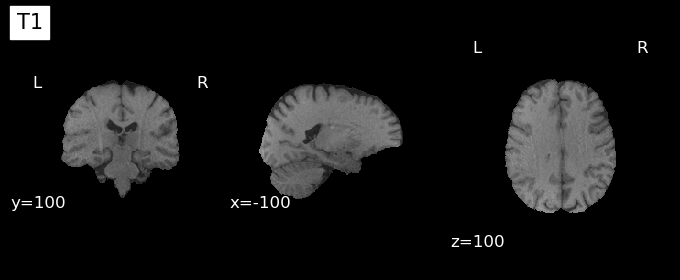

In [5]:
plotting.plot_anat(T1,cut_coords=[-100, 100, 100],title="T1",draw_cross =False)

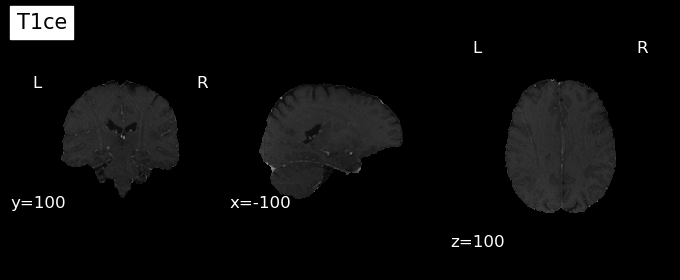

In [6]:
plotting.plot_anat(T1ce,cut_coords=[-100, 100, 100],title="T1ce",draw_cross =False)

**T2 weighted image :**


**T2 weighted image (T2WI) is one of the basic pulse sequences in MRI. The sequence weighting highlights differences in the T2 relaxation time of tissues.**

**The amount of T2 decay a tissue experiences depends on multiple factors. Each tissue has an inherent T2 value, but external factors (such as magnetic field inhomogeneity) can decrease the T2 relaxation time. This additional effect is captured in T2*. The refocusing pulse in spin-echo sequences helps to mitigate these extraneous influences on the T2 relaxation time, trying to keep the image T2 weighted rather than T2* weighted.**

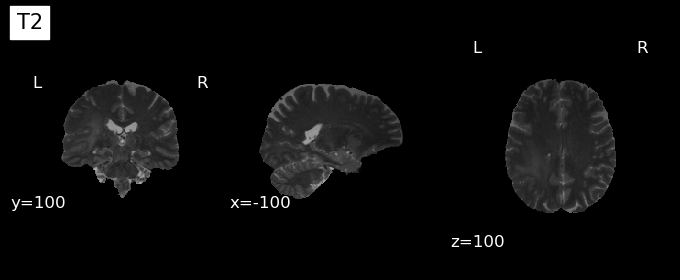

In [7]:
plotting.plot_anat(T2,cut_coords=[-100, 100, 100],title="T2",draw_cross =False)

# Data Preprocessing

In [8]:
Path= 'F://Thesis Group T2230051/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []
def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:      
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities
for i in p[:20]:
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)


**Check the output**

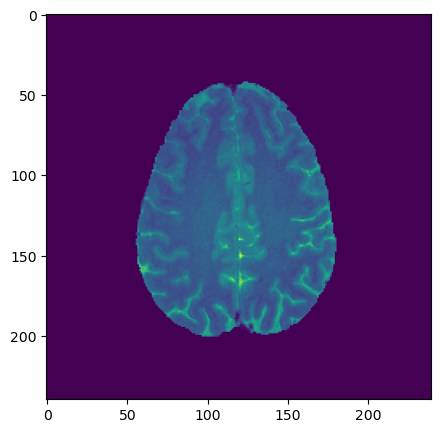

In [9]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[1][100,:,:,3]
imgplot = plt.imshow(immmg)
plt.show()

**concatenate images**

In [10]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

In [11]:
InData= Data_Concatenate(Input_Data)

$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)


In [12]:
AIO= concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,1],dtype='float32')
TRL=np.array(AIO[:,:,:,4],dtype='float32')

In [13]:
X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=42)
AIO=TRL=0

In [14]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c
#ddeplabv3+
def convolution_block(block_input,num_filters=128, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)
    print("Inside dspp, out_pool: ", out_pool.shape)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [15]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((240, 240, 1))
    
    ## Encoder
    e0 = inputs
    c1 = convolution_block(e0)
    d1 = DilatedSpatialPyramidPooling(c1)
    
    e1 = stem(d1, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [16]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [17]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Inside dspp, out_pool:  (None, 240, 240, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 12  1152        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 12  512        ['conv2d[0][0]']                 
 alization)                     8)              

 rmalization)                   )                                                                 
                                                                                                  
 activation (Activation)        (None, 240, 240, 16  0           ['batch_normalization_7[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 240, 240, 16  2064        ['tf.nn.relu_6[0][0]']           
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 240, 240, 16  2320        ['activation[0][0]']             
                                )                                                                 
          

                                                                                                  
 conv2d_17 (Conv2D)             (None, 30, 30, 128)  147584      ['activation_6[0][0]']           
                                                                                                  
 add_3 (Add)                    (None, 30, 30, 128)  0           ['batch_normalization_17[0][0]', 
                                                                  'conv2d_17[0][0]']              
                                                                                                  
 batch_normalization_18 (BatchN  (None, 30, 30, 128)  512        ['add_3[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 activation_7 (Activation)      (None, 30, 30, 128)  0           ['batch_normalization_18[0][0]'] 
          

                                                                                                  
 conv2d_29 (Conv2D)             (None, 60, 60, 128)  41088       ['concatenate_3[0][0]']          
                                                                                                  
 activation_14 (Activation)     (None, 60, 60, 128)  0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 60, 60, 128)  512        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_28 (Conv2D)             (None, 60, 60, 128)  147584      ['activation_14[0][0]']          
                                                                                                  
 add_6 (Ad

__________________________________________________________________________________________________


In [18]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def iou(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


In [19]:
Adam=optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity,iou])

In [20]:
history = model.fit(X_train,Y_train,batch_size=32,epochs=10,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/5
66/66 [==============================] - 5925s 90s/step - loss: 0.0565 - accuracy: 0.9694 - dice_coef: 0.4653 - precision: 333787936.0000 - sensitivity: 0.6149 - specificity: 0.9782 - iou: 0.3341 - val_loss: 0.3290 - val_accuracy: 0.9885 - val_dice_coef: 2.2037e-05 - val_precision: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_specificity: 0.9982 - val_iou: 2.2037e-05
Epoch 2/5
66/66 [==============================] - 5914s 90s/step - loss: -0.0421 - accuracy: 0.9866 - dice_coef: 0.7838 - precision: 0.6732 - sensitivity: 0.7474 - specificity: 0.9952 - iou: 0.6536 - val_loss: 2.3569 - val_accuracy: 0.8137 - val_dice_coef: 0.0407 - val_precision: 0.0105 - val_sensitivity: 0.2001 - val_specificity: 0.8230 - val_iou: 0.0208
Epoch 3/5
66/66 [==============================] - 5918s 90s/step - loss: -0.0632 - accuracy: 0.9869 - dice_coef: 0.8820 - precision: 0.6746 - sensitivity: 0.8188 - specificity: 0.9954 - iou: 0.8068 - val_loss: 1.3051 - val_accuracy: 0.8269 - val_dice_coef: 0

In [22]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 328s 22s/step - loss: -0.0313 - accuracy: 0.9823 - dice_coef: 0.7621 - precision: 0.4061 - sensitivity: 0.8443 - specificity: 0.9896 - iou: 0.6296


[-0.031346701085567474,
 0.982312023639679,
 0.762075662612915,
 0.40610259771347046,
 0.8443344235420227,
 0.9895707964897156,
 0.6296144723892212]

In [23]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# # Loss vs Epoch
# def Loss_Graph(history):

#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     #plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper left')
#     plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
#                         wspace=0.35)
#     plt.show()

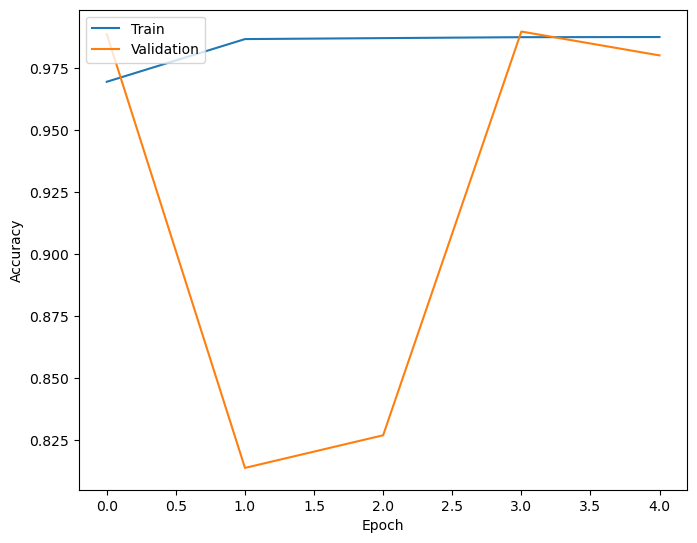

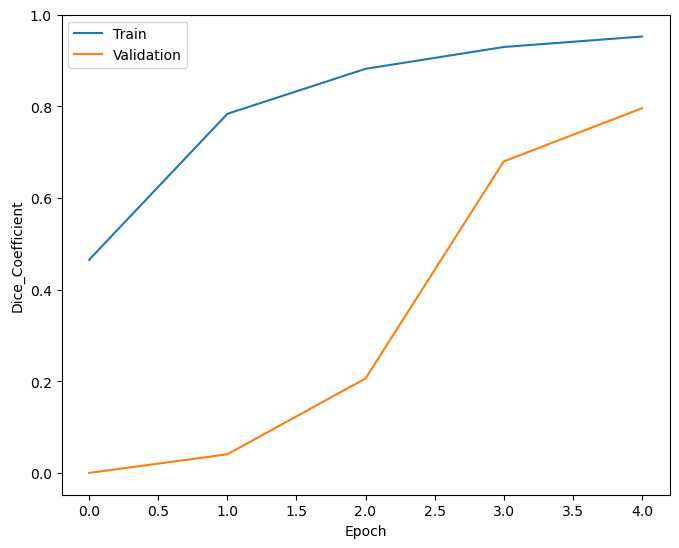

In [24]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
# Loss_Graph(history)

In [25]:
model.save('C://Users/20201131/Downloads/archive/saved_model/BraTs2020_rkb.h5')

In [26]:
X_train=X_test=Y_train=Y_test=0

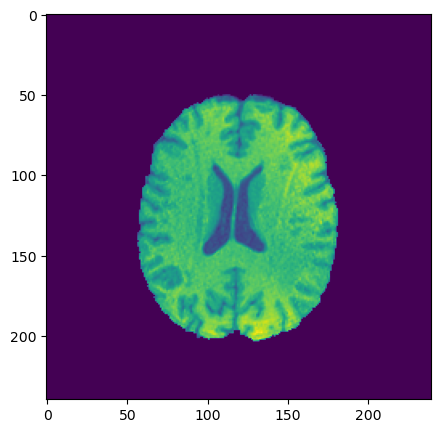

In [27]:
fig = plt.figure(figsize=(5,5))
immmg = TR[400,:,:]
imgplot = plt.imshow(immmg)
plt.show()

In [28]:
pref_Tumor = model.predict(TR)

97/97 [==============================] - 2182s 22s/step


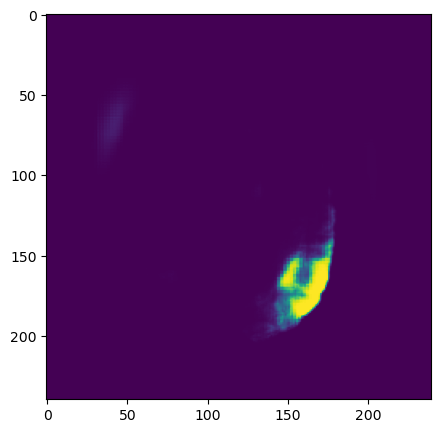

In [29]:
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[400,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

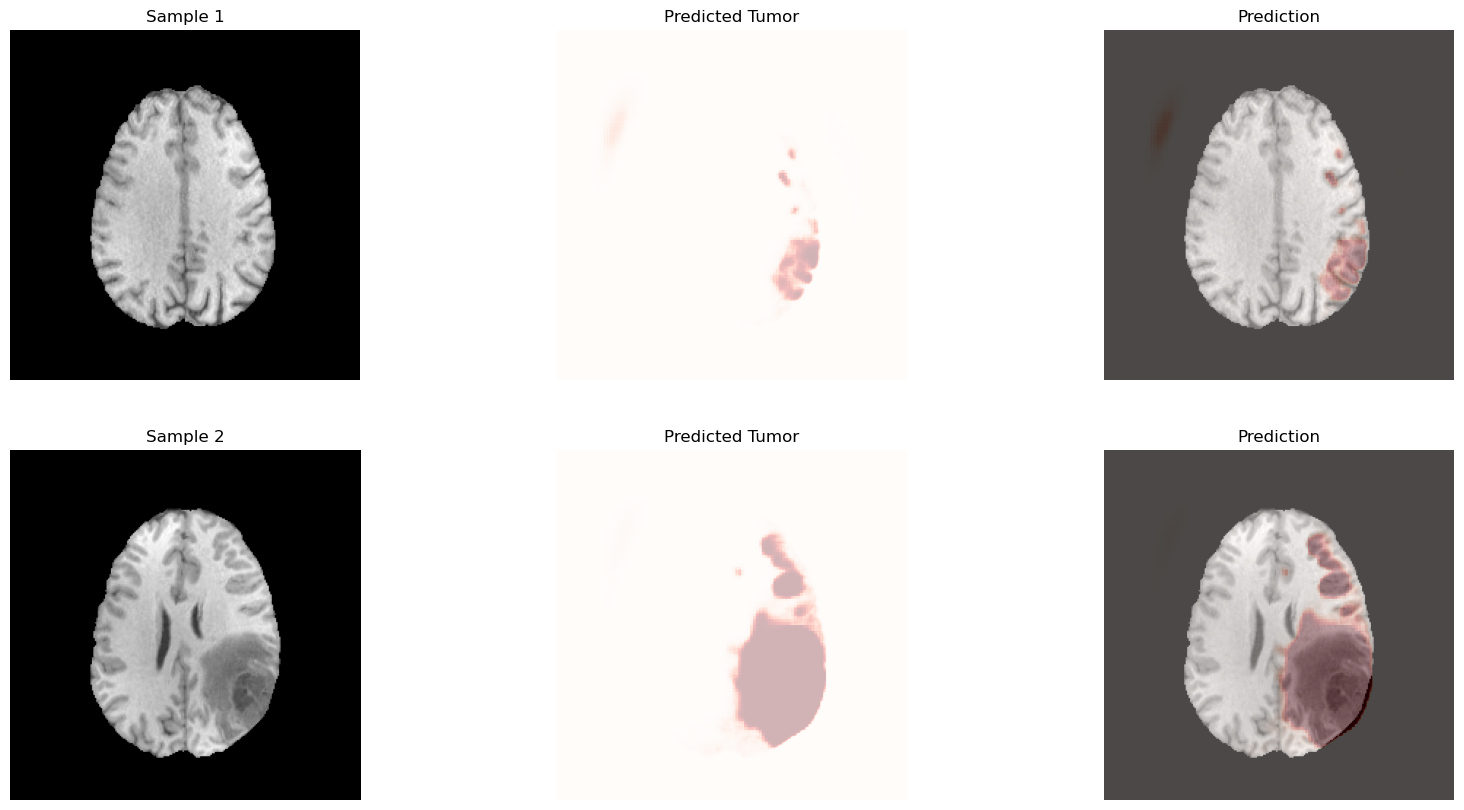

In [30]:
plt.figure(figsize=(20,10))


plt.subplot(231)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(TR[250,:,:]),cmap='gray')


plt.subplot(232)
plt.title('Predicted Tumor')
plt.axis('off')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(233)
plt.title('Prediction')
plt.axis('off')
plt.imshow(np.squeeze(TR[250,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')


plt.subplot(234)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(TR[550,:,:]),cmap='gray')


plt.subplot(235)
plt.title('Predicted Tumor')
plt.axis('off')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(236)
plt.title('Prediction')
plt.axis('off')
plt.imshow(np.squeeze(TR[550,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')